In [1132]:
# Hyperparameters
test_results = True
T = 15
N = 40
n_from_index = 0 # How distant the first point is

In [1133]:
import gym_duckietown
import matplotlib.pyplot as plt
import numpy as np

from gym_duckietown.simulator import Simulator
from casadi import *

import utils
from utils import get_position, my_odometry


In [1134]:
plt.rcParams['figure.figsize'] = [7, 7]

In [1135]:
#gym_duckietown is very chatty
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

In [1136]:
env = Simulator("ETH_large_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[3,1],
    seed=42,
    max_steps=float("inf"),
    robot_speed=1.0,
)

In [1137]:
env.unwrapped.start_pose = [[0.11699990272521976, 0, 0.41029359288296474], pi/2]

In [1138]:
dt = 1.0 / env.frame_rate

In [1139]:
env.reset()
traj = utils.get_trajectory(env, samples=500, method="distance", last_value_distance=1.035)

/home/giulio/prog/duckrace_simulator/utils.py:316: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points_fitted = np.vstack( spl(alpha) for spl in splines ).T


In [1140]:
pose = get_position(env)
pose

Position(x=1.8719999027252197, y=1.9297064071170351, theta=1.5707963267948966)

Text(1.9486294618007634, 1.9308421914242628, '|---------|')

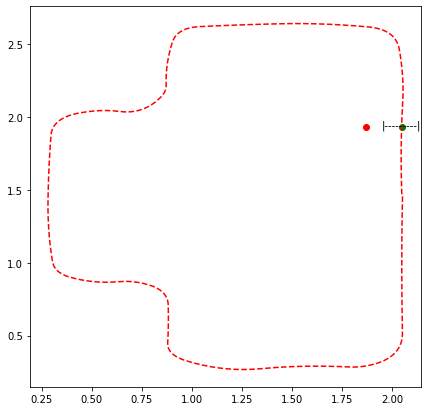

In [1141]:
from scipy import spatial
distance,index = spatial.KDTree(traj).query([pose.x, pose.y])
index += n_from_index
startpoint = (traj[index,0], traj[index,1])
plt.plot(*traj.T, "r--")
plt.scatter(pose.x, pose.y, c="r")
plt.scatter(traj[index,0], traj[index,1], c="g")
plt.text(startpoint[0]-0.1, startpoint[1], '|'+'-'*9+'|')

In [1142]:
f"Samples must be at least: {np.round(np.sum( np.sqrt(np.sum( np.diff(traj, axis=0)**2, axis=1 )) ) / (0.6*dt))}"

'Samples must be at least: 376.0'

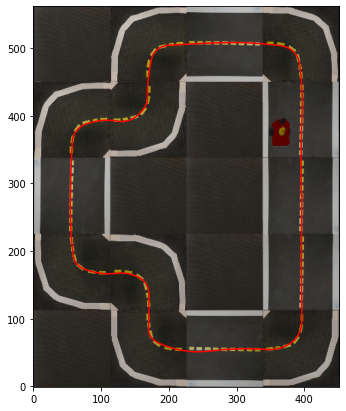

In [1143]:
utils.show_on_map_array(env, traj[:,:2])

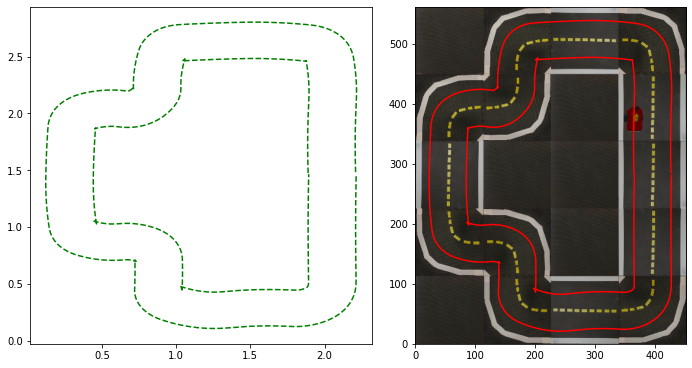

In [1144]:
inside, outside = utils.get_border(traj, distance=0.16)
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
ax_dict = fig.subplot_mosaic("""AB""")
ax_dict["A"].plot(*inside.T, "g--")
ax_dict["A"].plot(*outside.T, "g--")
utils.show_on_map_array(env, inside, fig=ax_dict["B"])
utils.show_on_map_array(env, outside, fig=ax_dict["B"])

In [1145]:
get_position(env)

Position(x=1.8719999027252197, y=1.9297064071170351, theta=1.5707963267948966)

In [1146]:
# Compute the angle between every consecutive points in traj
angles = np.zeros(traj.shape[0])
angles[:-1] = np.arctan2(traj[1:,1]-traj[:-1,1], traj[1:,0]-traj[:-1,0])
angles[-1] = np.arctan2(traj[0,1]-traj[-1,1], traj[0,0]-traj[-1,0])

In [1147]:
# Add angles to traj
traj = np.concatenate((traj, angles.reshape(-1,1)), axis=1)

In [1148]:
traj[index]

array([2.04862946, 1.93084219, 1.54813545])

In [1149]:
index = DM(index)
traj = DM(traj)
out = DM(outside)
ins = DM(inside)

Trajectory CasaDi function

In [1150]:
out = SX.sym("out", 2, 2)
ins = SX.sym("ins", 2, 2)
a = SX.sym('alpha',1)
t = ins + a*(out-ins)
ang = arctan2(t[1,1]-t[0,1], t[1,0]-t[0,0])
res = horzcat(t[0,:], ang).T
get_traj = Function('get_traj',[a, out, ins],[res])
print(get_traj)

get_traj:(i0,i1[2x2],i2[2x2])->(o0[3]) SXFunction


Initialize states, inputs, and system dynamic equation

In [1151]:
pose = get_position(env)

In [1152]:
delay = round(0.15/dt)
u_delay0 = DM(np.zeros((2, delay)))
# N += delay

# Initial reference point
r0 = repmat(traj[index, :2].T, 1, N+1)
# Initial reference angles
t0 = repmat(traj[index, 2].T, 1, N+1)

# With preview
# Initial reference point
r0 = traj[index:index+N+1, :2].T
t0 = traj[index:index+N+1, 2].T

In [1153]:
F = utils.model_F(dt=dt)

In [1154]:
mod = utils.casadi_mod

In [1155]:
get_traj(0.5, out[:, 0:0+2], ins[:, 0:0+2])[:2]

SX(@1=0.5, [(ins_0+(@1*(out_0-ins_0))), (ins_2+(@1*(out_2-ins_2)))])

In [1156]:
opti = Opti()

x = opti.variable(5,N+1)    # States with dimension (n_x, prediction_horizon+1) (x(0),...,x(N+1))
u = opti.variable(2,N)#-delay)      # Inputs with dimension (n_u, prediction_horizon) (u(0),...,u(N))
alpha = opti.variable(1,N+1) # Parameter to set the trajectory
p = opti.parameter(5,1)     # Parameter to set the initial state conditions (x(0))
r = opti.variable(2,N+1)   # Parameter to set the initial index
tr = opti.variable(1,N+1)   # Parameter to set the initial reference angles
u_delay = opti.parameter(2,delay) # Parameter to set the delay
ins = opti.parameter(2,N+2) # Parameter to set the inside points
out = opti.parameter(2,N+2) # Parameter to set the outside points

Q = opti.parameter(1)
Q2 = opti.parameter(1)
Q3 = opti.parameter(1)
R = opti.parameter(1)
# T = opti.parameter(1)

# With delay:
# Q, Q2, Q3, R = 100, 5e-4, 1, 1e-3
T1, T2 = 0, 5e3
obj = Q*sumsqr(x[:2, :]-r) + Q2*sumsqr(mod(x[2, :]-tr+pi, 2*pi)-pi) + Q3*sumsqr(x[3, :]-0.6) + R*sumsqr(u) + T1*sumsqr(alpha[1:]-alpha[:-1]) + T2*sumsqr(r[:, 1:]-r[:, :-1])
# atan method is faster than mod (20s vs 23s on 1000 iterations) but it allows car to go backward
# obj = Q*sumsqr(x[:2, :]-r) + Q2*sumsqr(atan2(sin(x[2, :]-tr), cos(x[2, :]-tr))) + R*sumsqr(u)

opti.minimize(obj)          # Setup the problem 

# Constraints Definition

# 1) System dynamics constraint over the prediction horizon
for k in range(0,N):
   # opti.subject_to(x[:,k+1]==F(x[:,k],horzcat(u_delay, u)[:, k])) # Horzacat to include delay
   opti.subject_to(x[:,k+1]==F(x[:,k],u[:,k])) # No delay
    
# 2) Additional states/inputs constraints 
opti.subject_to(vec(u) <= 1)
opti.subject_to(vec(u) >= -1)
# 3) Force the state variable at instant 0 to be equal to the parameter value containing x0 value
opti.subject_to(x[:,0] == p)
# 4) Alpha between 0 and 1
opti.subject_to(alpha >= 0)
opti.subject_to(alpha <= 1)
# 5) Force the reference point to be along the line of alpha
for k in range(0,N):
   opti.subject_to(r[:, k] == ins[:, k] + alpha[k]*(out[:, k]-ins[:, k])) 
   opti.subject_to(tr[:, k] == get_traj(alpha[k], out[:, k:k+2], ins[:, k:k+2])[2])

opti.set_value(p,[pose.x, pose.y, pose.theta, 0, 0]) # Set the initial x0 value
opti.set_value(u_delay, u_delay0) # Initial delay

opti.set_value(Q, 100)
opti.set_value(Q2, 5e-4)
opti.set_value(Q3, 1)
opti.set_value(R, 1e-3)

# Ipopt
opts = dict()
opts["ipopt.print_level"] = 0
opts["print_time"] = False
opti.solver('ipopt',opts)


In [1157]:
# This instruction transfom all the Opti problem defined above into a callable function
M = opti.to_function('M',[p, ins, out, u_delay, Q, Q2, Q3, R],[u[:,0], alpha],['p', 'ins', 'out', 'u_delay', 'Q', 'Q2', 'Q3', 'R'],['u_opt', 'alpha_opt'])

In [1158]:
# MPC loop
F = utils.model_F(dt=dt)
X_log = np.empty((5,0))
U_log = np.empty((2,0))

x = [pose.x, pose.y, pose.theta, 0, 0]
ins = DM(inside)
out = DM(outside)
idx = index.toarray()[0][0]
u_delay = u_delay0
errors = []
error_x = []
error_y = []
error_theta = []
alphas = []

kdtree = spatial.KDTree(traj[:, :2])

iteration = 0
while True:
    u, alpha = M(x, ins[idx:idx+N+2,:].T, out[idx:idx+N+2,:].T, u_delay, 100, 5e-4, 1, 1e-3)

    alphas.append([idx, alpha[0].toarray()[0,0]])

    U_log = np.column_stack((U_log, u))
    X_log = np.column_stack((X_log, x))

    u_delay = np.column_stack((u_delay, u))[:, -delay:]

    # simulate
    x = F(x,u)

    distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2
    errors.append(distance)
    error_x.append(traj[idx, 0] - x[0])
    error_y.append(traj[idx, 1] - x[1])
    error_theta.append(mod(x[2]-traj[idx, 2]+pi, 2*pi)-pi)

    _,idx_new = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
    if idx_new >= idx:
        idx = idx_new
    # if idx+N+1 < traj.shape[0]:
    #     r = traj[idx:idx+N+1, :2].T
    #     tr = traj[idx:idx+N+1, 2].T
    # else:
    #     r = vertcat(traj[idx:, :2], traj[:idx+N+1-traj.shape[0], :2]).T
    #     tr = vertcat(traj[idx:, 2], traj[:idx+N+1-traj.shape[0], 2]).T

    if iteration > 400:
        break
    iteration += 1

CasADi - 2022-03-14 21:10:26 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1009 (row 449, col 285).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-03-14 21:10:26 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1009 (row 449, col 285).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-03-14 21:10:26 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1009 (row 449, col 285).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-03-14 21:10:26 WARNING("solver:nlp_grad failed: NaN detected for output grad_gamma_p, at (row 5, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-03-14 21:10:26 WARNING("Failed to calculate multipliers") [.../casadi/core/nlpsol.cpp:621]


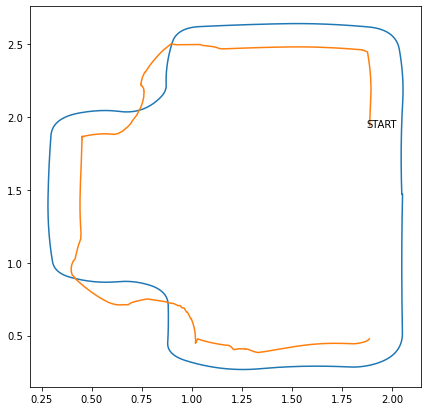

In [1159]:
alphas = np.array(alphas)
res_traj = inside[alphas[:,0].astype(int)] + alphas[:,1].reshape(-1,1)*(outside[alphas[:,0].astype(int)] - inside[alphas[:,0].astype(int)])
plt.text(X_log[0,0], X_log[1,0], 'START')
plt.plot(traj[:,0], traj[:,1])
plt.plot(*res_traj.T)

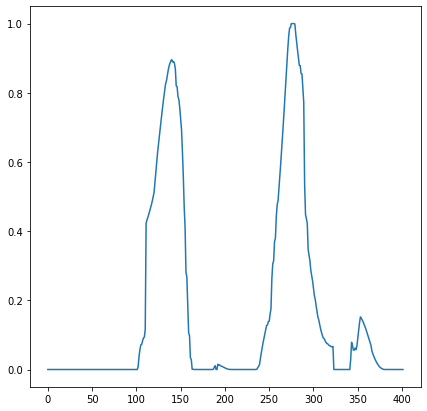

In [1160]:
plt.plot(alphas[:,1])

In [1161]:
f"Max reached speed: {X_log[3,:].max()}, max speed is 0.6"

'Max reached speed: 0.5856796950358575, max speed is 0.6'

In [1162]:
errors = np.array(errors).reshape(-1)
f"Mean error: {errors.mean()}"

'Mean error: 0.01948691858596436'

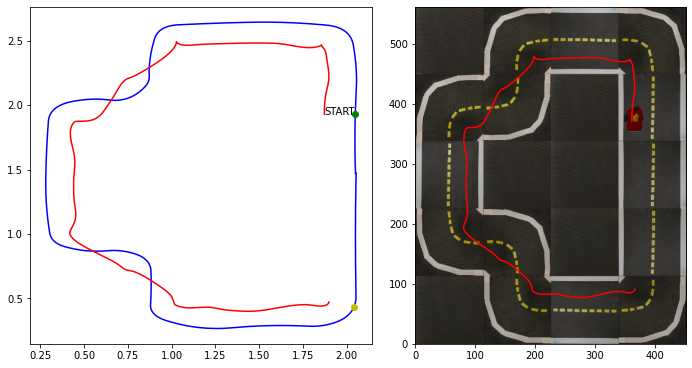

In [1163]:
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
ax_dict = fig.subplot_mosaic("""AC
        AC""")
ax_dict["A"].text(X_log[0,0], X_log[1,0], 'START')
ax_dict["A"].plot(traj[:,0], traj[:,1], "b")
ax_dict["A"].plot(traj[index,0], traj[index,1], 'go')
ax_dict["A"].plot(X_log[0,:], X_log[1,:], "r")
ax_dict["A"].plot(traj[idx, 0], traj[idx,1], 'yo')
# ax_dict["B"].plot(np.arange(len(errors))*dt, np.sqrt(errors))
utils.show_on_map_array(env, np.array([X_log[0,:], X_log[1,:]]).T, fig=ax_dict["C"])

Text(0.5, 0, 'Time (s)')

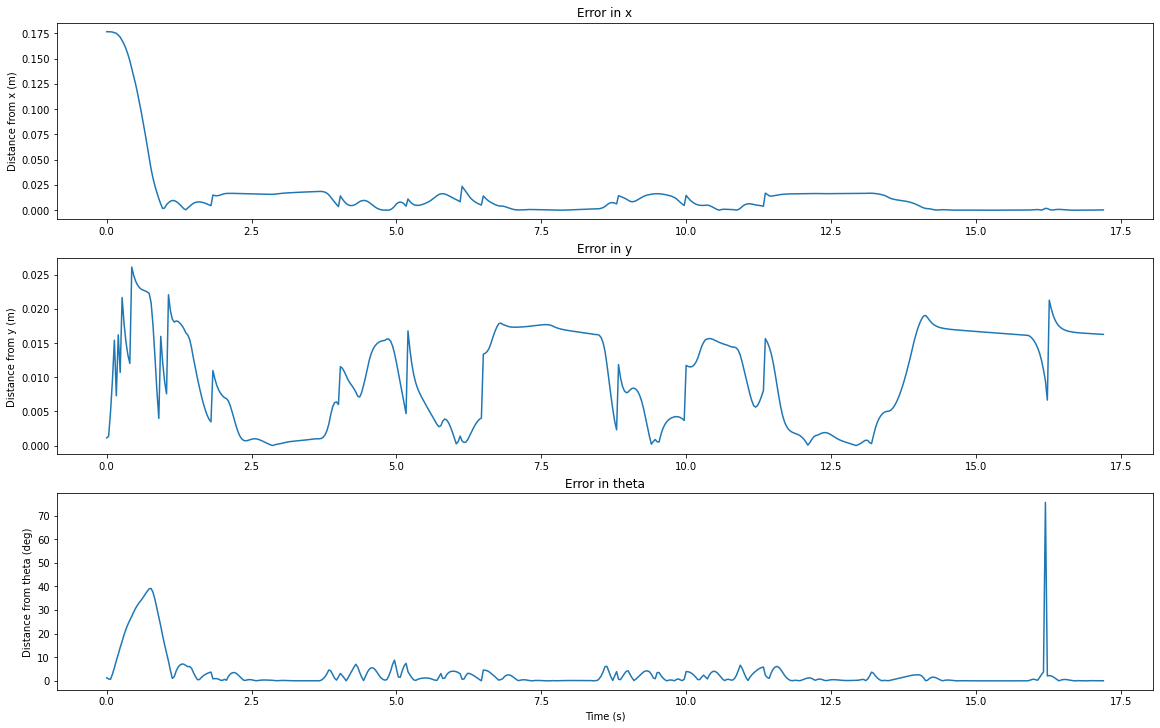

In [35]:
fig = plt.figure(constrained_layout=True, figsize=(16, 10))
ax_dict = fig.subplot_mosaic("""A
        B
        C""")
error_x = np.array(error_x).reshape(-1)
ax_dict["A"].plot(np.arange(len(error_x))*dt, np.abs(error_x))
ax_dict["A"].set_title("Error in x")
ax_dict["A"].set_ylabel("Distance from x (m)")
error_y = np.array(error_y).reshape(-1)
ax_dict["B"].plot(np.arange(len(error_y))*dt, np.abs(error_y))
ax_dict["B"].set_title("Error in y")
ax_dict["B"].set_ylabel("Distance from y (m)")
error_theta_scaled = np.rad2deg(np.array(error_theta).reshape(-1))
ax_dict["C"].plot(np.arange(len(error_theta_scaled))*dt, np.abs(error_theta_scaled))
ax_dict["C"].set_title("Error in theta")
ax_dict["C"].set_ylabel("Distance from theta (deg)")
ax_dict["C"].set_xlabel("Time (s)")

### Gym simulation

The MPC does not consider the delay yet!

In [31]:
record = False

if record:
    import imageio
    import cv2

    env.reset()
    pose = get_position(env)
    images = []
    positions = []
    odoms = [pose]
    actions = [[0,0]]*10
    v0 = 0
    w0 = 0
    for action in U_log.T:
        env.step(action)
        positions.append(get_position(env))
        img = env.render(mode='rgb_array')
        img = cv2.resize(img, dsize=(400, 300), interpolation=cv2.INTER_CUBIC)
        images.append(img)

        p, v0, w0 = my_odometry(action, odoms[-1].x, odoms[-1].y, odoms[-1].theta, v0, w0, dt=dt)
        odoms.append(p)
        actions.append(action)

    imageio.mimsave("assets/mpc_run.gif", images, format='GIF', fps=env.frame_rate)

In [32]:
if record:
    plt.plot(*np.array([[p.x, p.y] for p in positions]).T, c='g', label='true', linewidth=5)
    plt.plot(*np.array([[p.x, p.y] for p in odoms]).T, c='r', label='odom')
    plt.legend()

In [33]:
if record:
    utils.show_on_map(env, positions)

In [34]:
from IPython.display import HTML, display
# Trick to prevent cache use
display(HTML('<img src="assets/mpc_run.gif?%d" width="750" align="center">' % np.random.randint(10)))